In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import enum
import os

import sys
# sys.path.append( '/content/drive/My Drive/thesis-workspace' ) # drive version
sys.path.append( '../../src/' ) # local version

from ml.preprocessing import *

# Classification

## Loading Datasets

In [4]:
class DF( enum.Enum ):
    _FULL = 1
    _REDUCED_RFE = 2
    _REDUCED_KBEST = 3
    _MIN = 4

# path = [ '.', 'drive', 'My Drive', 'thesis-workspace', 'datasets' ]
path = [ '..', '..', 'datasets', 'feature_selection' ]

df = {}
df[ DF._FULL ] = pd.read_csv( os.path.join( *path, 'ds-home-fs-full.csv' ) , index_col = 'date', parse_dates = [ 'date' ] )
df[ DF._REDUCED_RFE ] = pd.read_csv( os.path.join( *path, 'ds-home-fs-rfe.csv' ), index_col = 'date', parse_dates = [ 'date' ] )
df[ DF._REDUCED_KBEST ] = pd.read_csv( os.path.join( *path, 'ds-home-fs-kbest.csv' ), index_col = 'date', parse_dates = [ 'date' ] )
df[ DF._MIN ] = pd.read_csv( os.path.join( *path, 'ds-home-fs-min.csv' ), index_col = 'date', parse_dates = [ 'date' ] )

## Data splitting, standarization and balancing

In [5]:
from imblearn.over_sampling import ADASYN
from collections import Counter


# Number of neighbors to use for balancing each dataset

neighbors = { 
    DF._FULL: 1,
    DF._REDUCED_RFE: 1,
    DF._REDUCED_KBEST: 1,
    DF._MIN: 1
}

for k, d in df.items() :  
    temp = list( split_data( d, test_size = 0.20 ) )
    temp[ X_TRAIN ], temp[ X_TEST ] = standardize( temp[ X_TRAIN ], temp[ X_TEST ] )
    
    print( 'Before balancing:', k, Counter( temp[ Y_TRAIN ] ) )
    temp[ X_TRAIN ], temp[ Y_TRAIN ] = balance_df( 
        temp[ X_TRAIN ], 
        temp[ Y_TRAIN ], 
        neighbors[ k ] )
    print( 'After balancing:', k, Counter( temp[ Y_TRAIN ] ) )
    print()
    
    df[ k ] = temp

Before balancing: DF._FULL Counter({'L': 16301, 'E': 4128, 'M': 2832, 'H': 531})
After balancing: DF._FULL Counter({'E': 16572, 'M': 16402, 'H': 16391, 'L': 16301})

Before balancing: DF._REDUCED_RFE Counter({'L': 16301, 'E': 4128, 'M': 2832, 'H': 531})
After balancing: DF._REDUCED_RFE Counter({'M': 16326, 'L': 16301, 'E': 16288, 'H': 16281})

Before balancing: DF._REDUCED_KBEST Counter({'L': 16301, 'E': 4128, 'M': 2832, 'H': 531})
After balancing: DF._REDUCED_KBEST Counter({'M': 16362, 'L': 16301, 'H': 16281, 'E': 16256})

Before balancing: DF._MIN Counter({'L': 16325, 'E': 4098, 'M': 2830, 'H': 547})
After balancing: DF._MIN Counter({'E': 16353, 'M': 16330, 'H': 16329, 'L': 16325})



## Training

In [6]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from ml.classification import *

params_knn = [ { 
    'n_neighbors': [ 1, 3, 5 ], 
    'p': [ 2 ], # mikowsky distance = euclidian distance
    'algorithm': [ 'ball_tree', 'kd_tree' ] # removed brute force due to the dataset size
} ]

grids = { DF._FULL: None, DF._REDUCED_RFE: None, DF._REDUCED_KBEST: None, DF._MIN: None }

labels = [ 'E', 'H', 'L', 'M' ]

# exclude = [ DF._REDUCED_RFE, DF._REDUCED_KBEST, DF._MIN ]
exclude = [  ]

### Regular

Dataset  DF._FULL
Best params:  {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 2}
Training Accuracy 0.9586696346443911
Test Accuracy:  0.7868549336022861
Test ROCauc (OvR): 0.7817064585603865

Detailed Classification Report
              precision    recall  f1-score   support

           E       0.72      0.75      0.74       998
           H       0.61      0.55      0.58       156
           L       0.86      0.85      0.86      4068
           M       0.51      0.53      0.52       727

    accuracy                           0.79      5949
   macro avg       0.68      0.67      0.67      5949
weighted avg       0.79      0.79      0.79      5949


Dataset  DF._REDUCED_RFE
Best params:  {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 2}
Training Accuracy 0.9851984807034088
Test Accuracy:  0.9231803664481425
Test ROCauc (OvR): 0.9180599877650123

Detailed Classification Report
              precision    recall  f1-score   support

           E       0.91      0.91      0.91     

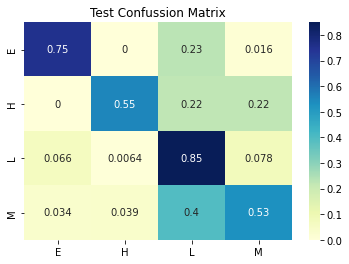

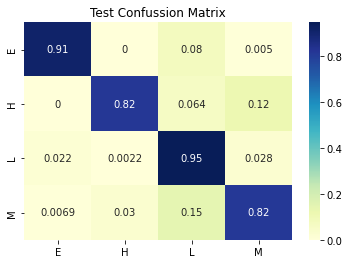

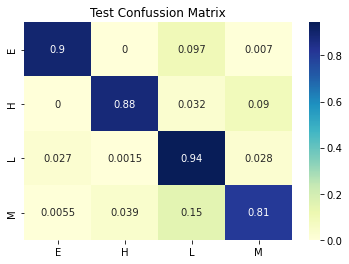

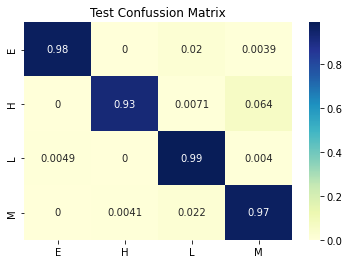

In [7]:
%%time
for k, d in df.items():
    if( k not in exclude ):
        print( 'Dataset ', k )
        grids[ k ] = train_and_test( 
                KNeighborsClassifier(), params_knn, 
                d[ X_TRAIN ], d[ Y_TRAIN ], 
                d[ X_TEST ], d[ Y_TEST ], 
                plot_cmatrix = True, labels = labels )

# Evaluation

In [8]:
from ml.evaluation import *

## Learning Curves

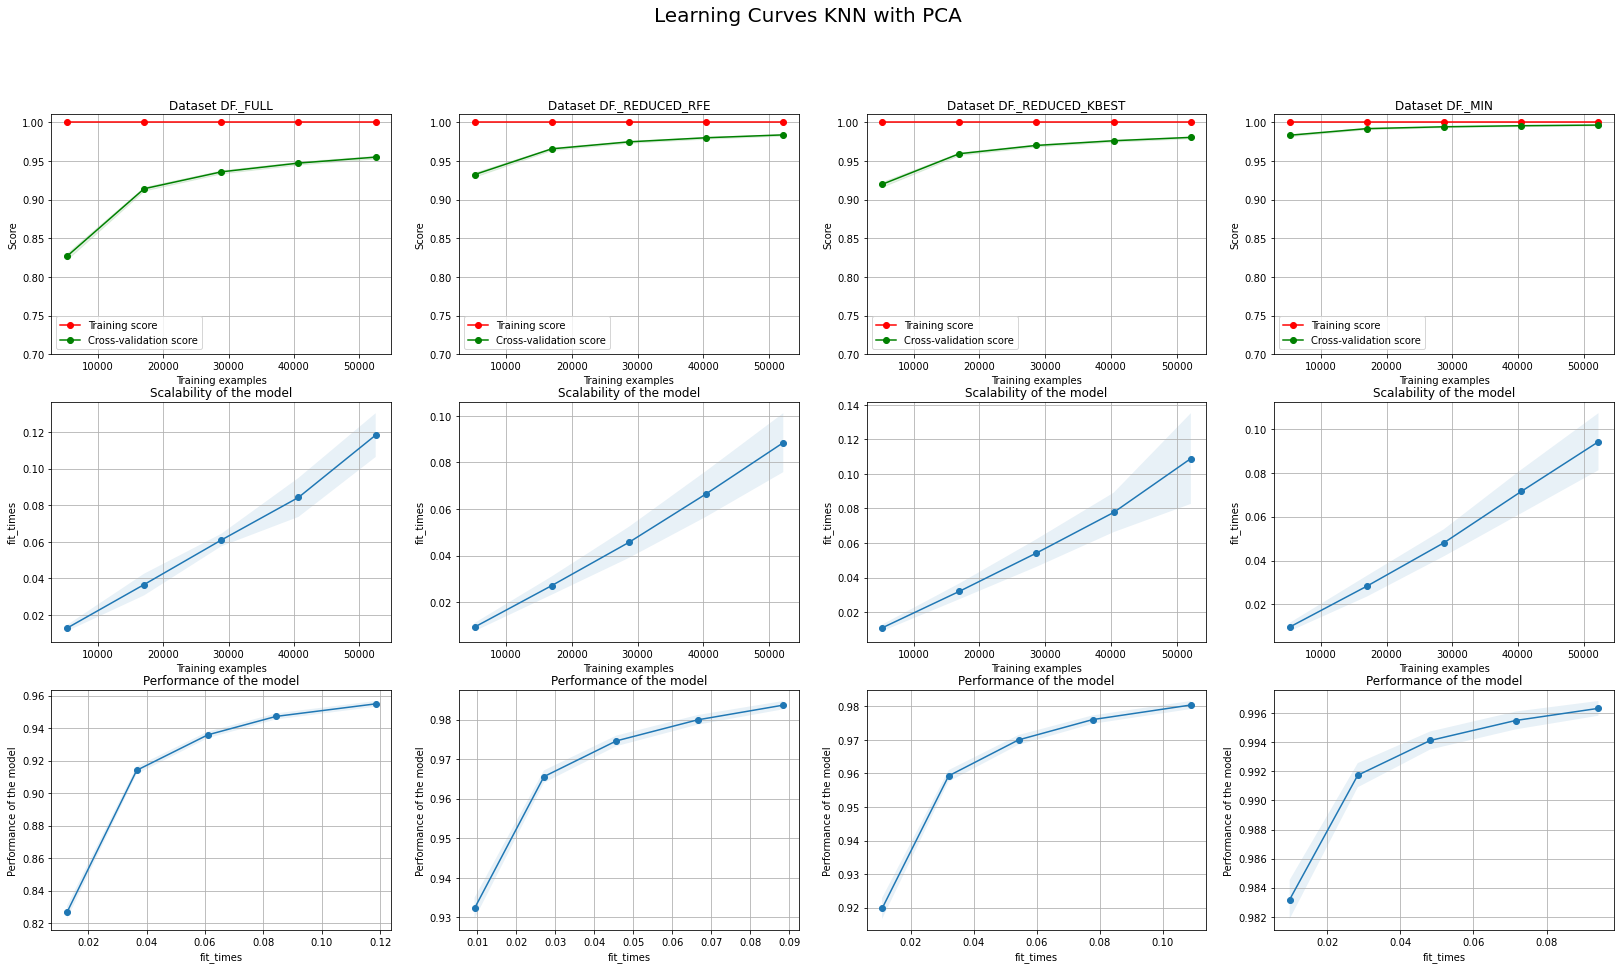

CPU times: user 17 s, sys: 803 ms, total: 17.8 s
Wall time: 1h 21min 11s


In [9]:
%%time
temp = [ item for item in df.items() if item[ 0 ] not in exclude ]
plot_learning_curves( temp, grids, 'KNN' )